<h2>Is "Grimms' Fairy Tales" Really Grim?</h2>
<h5><i>By Kyoosik Kim</i></h5>

------
### Practical Analysis with Gutenberg Project
Some of the stories in <a href="https://en.wikipedia.org/wiki/Grimms%27_Fairy_Tales">"Grimms' Fairy Tales"</a> by Grimm bothers are said to have gruesome scenes even if part of them were reenacted into movies or animations for children todays. One question that we can throw here is "Is it really grim?" and this could be answered by looking at all the words included in the tales. The following program is devised to read a hundred of words in an instance and count the grim words given as a list.
For the fair comparison, the program will also count cheery words and do the same job to <a href="https://en.wikipedia.org/wiki/Pride_and_Prejudice">"Pride and Prejudice"</a>. The novel by Jane Austen is a quite suitable for the control group since it is neither grim or cheery in general.

------
### 1. Preparation

In [1]:
# libraries
import re
import pandas as pd
from statistics import mean
import matplotlib.pyplot as plt

In [2]:
# word lists
GRIM_WORDS = open('Data/grim_words.txt').read().splitlines()
CHEERY_WORDS = open('Data/cheery_words.txt').read().splitlines()

#### - Functions for Reading and Cleaning

In [3]:
"""
Find the point of start by the full title
"""
def process_intro(data, title):
    start_idx = 0
    
    for line in data:
        if line.replace('\n', '') == title:
            return data[start_idx+5:] # skip empty lines
        start_idx = start_idx + 1
    
    print("Error: title not found")
    return data 

In [4]:
"""
Set chapters into a dictionary and process paragraphs
"""
def process_paragraph(data):
    story_dict = {}
    chapter = "" # or individual tale
    paragraph = ""
    
    for line in data:
        line = line.replace('\n', "")
        
        # end of contents
        if line == "*****" or line.startswith("End of the Project Gutenberg"):
            return story_dict
        
        if re.match(r'[\w]', line) and (line.isupper() or line.startswith("Chapter")):
            chapter = line
            story_dict[chapter] = []
        elif line == "": # next paragraph
            if paragraph: # exclude empty paragraph
                story_dict[chapter].append([paragraph.strip()])
            paragraph = ""
        else: # add sentences to paragraph
            paragraph = paragraph + line.strip() + " "
    
    print("Error: a dictionary built but found no end")
    return story_dict

In [5]:
"""
Read file and call functions to process it
"""
def read_file(filepath, title):
    with open(filepath, 'r') as f:
        data = f.readlines()
        data = process_intro(data, title)
        data = process_paragraph(data)
        
        return data

#### - Functions for Analyzing

In [6]:
"""
Count grim words and cheery words, plus total number of words
"""
def word_match(chapter):
    grim_word_count = 0
    cheery_word_count = 0
    total_count = 0
    grim_words = []
    cheery_words = []
    
    for paragraph in chapter:
        words = paragraph[0].split(" ")
        for word in words:
            word = re.sub(r'[^\w]', '', word)
            if word in GRIM_WORDS:
                grim_word_count = grim_word_count + 1
                grim_words.append(word)
            elif word in CHEERY_WORDS:
                cheery_word_count = cheery_word_count + 1
                cheery_words.append(word)
            total_count = total_count + 1
    
    return (grim_word_count, cheery_word_count, total_count, 
            grim_words, cheery_words, len(chapter))

In [7]:
"""
Call word_count and return the result in Data Frame
"""
def extract_result(story):
    grim_total = []
    cheery_total = []
    final_total = []
    grim_words_list = []
    cheery_words_list = []
    paragraph_num = []

    for chapter in story.keys(): # loop through each chapter/story
        grim, cheery, total, grim_words, cheery_words, paragraph = word_match(story[chapter])
        # build lists for Data Frame
        grim_total.append(grim)
        cheery_total.append(cheery)
        final_total.append(total)
        grim_words_list.append(grim_words)
        cheery_words_list.append(cheery_words)
        paragraph_num.append(paragraph)
    
    # to Data Frame
    result = {'chapter': list(story.keys()), 'grim_total': grim_total, 'grim_words': grim_words_list,
              'cheery_total': cheery_total, 'cheery_words': cheery_words_list,
              'total': final_total, 'paragraph': paragraph_num}
    df = pd.DataFrame(data=result)
    
    # grim/cheery words per 1,000 words
    df['grim_per_k'] = df['grim_total']/df['total']*1000
    df['cheery_per_k'] = df['cheery_total']/df['total']*1000
    
    return df

In [8]:
"""
Calculate simple statistics and print them
"""
def print_summary(df):
    print("Total Grim Words:", sum(df['grim_total']))
    print("Total Cheery Words:", sum(df['cheery_total']))
    print("Average Grim Words per 1,000 Words:", round(mean(df['grim_per_k']), 3))
    print("Average Cheery Words per 1,000 Words:", round(mean(df['cheery_per_k']), 3))
    print("Grim to Cheery Ratio:", round(sum(df['grim_total'])/sum(df['cheery_total']), 3))
    print("Grim Words per Paragraph:", round(sum(df['grim_total'])/sum(df['paragraph']), 3))

In [9]:
"""
Read each word and count how many the same word is in a list
"""
def word_count(word_list):
    word_list = sorted(word_list)
    word_dict = {}
    
    this_word = word_list[0]
    count = 0
    for word in word_list:
        if word != this_word:
            word_dict[this_word] = count
            this_word = word
            count = 1
        else:
            count = count + 1
    
    word_dict[this_word] = count
    word_df = pd.DataFrame({'word': list(word_dict.keys()), 'count': list(word_dict.values())})
    
    return word_df

In [10]:
"""
Call word_count and return as data frame
"""
def word_df(df):
    grim_list = []
    cheery_list = []
    
    for g, c in zip(df['grim_words'], df['cheery_words']):
        for word in g:
            grim_list.append(word)
        for word in c:
            cheery_list.append(word)
        
    grim_df = word_count(grim_list).sort_values('count', ascending=False)
    cheery_df = word_count(cheery_list).sort_values('count', ascending=False)
    
    return grim_df, cheery_df

------
### 2. Load and Analysis

In [11]:
grimms_fairy_tales = read_file('Data/Grimms_Fairy_Tales.txt', "THE BROTHERS GRIMM FAIRY TALES")
assert str(grimms_fairy_tales['HANSEL AND GRETEL'][1][0]).startswith("The two children")
assert len(grimms_fairy_tales.keys()) == 62

grimms_df = extract_result(grimms_fairy_tales)
grimms_df.head(10)

,chapter,grim_total,grim_words,cheery_total,cheery_words,total,paragraph,grim_per_k,cheery_per_k
0,THE GOLDEN BIRD,3,"[kill, kill, kill]",1,[life],2527,19,1.187178,0.395726
1,HANS IN LUCK,2,"[kill, grave]",7,"[born, heart, heart, born, heart, born, heart]",2351,19,0.850702,2.977456
2,JORINDA AND JORINDEL,0,[],0,[],1133,16,0.000000,0.000000
3,THE TRAVELLING MUSICIANS,0,[],3,"[life, heart, being]",1361,8,0.000000,2.204262
4,OLD SULTAN,1,[kill],0,[],870,5,1.149425,0.000000
5,"THE STRAW, THE COAL, AND THE BEAN",0,[],1,[heart],503,4,0.000000,1.988072
6,BRIAR ROSE,0,[],0,[],1510,10,0.000000,0.000000
7,THE DOG AND THE SPARROW,3,"[kill, kill, kill]",4,"[life, life, life, life]",1342,2,2.235469,2.980626
8,THE TWELVE DANCING PRINCESSES,0,[],1,[life],1601,12,0.000000,0.624610
9,THE FISHERMAN AND HIS WIFE,0,[],3,"[heart, being, being]",2115,25,0.000000,1.418440


In [12]:
pride_and_prejudice = read_file('Data/Pride_And_Prejudice.txt', "PRIDE AND PREJUDICE")
pride_df = extract_result(pride_and_prejudice)
pride_df.head(10)

,chapter,grim_total,grim_words,cheery_total,cheery_words,total,paragraph,grim_per_k,cheery_per_k
0,Chapter 1,0,[],1,[life],847,34,0.000000,1.180638
1,Chapter 2,0,[],1,[life],796,27,0.000000,1.256281
2,Chapter 3,0,[],10,"[heart, being, being, being, being, being, lif...",1692,20,0.000000,5.910165
3,Chapter 4,0,[],4,"[being, life, being, life]",1053,16,0.000000,3.798670
4,Chapter 5,0,[],3,"[being, being, being]",946,23,0.000000,3.171247
5,Chapter 6,1,[grave],9,"[being, heart, being, heart, life, being, ener...",2338,54,0.427716,3.849444
6,Chapter 7,1,[dying],6,"[life, heart, activity, impulse, activity, being]",1979,48,0.505306,3.031834
7,Chapter 8,0,[],7,"[being, being, heart, heart, heart, being, being]",1927,59,0.000000,3.632590
8,Chapter 9,0,[],3,"[being, being, being]",1726,39,0.000000,1.738123
9,Chapter 10,0,[],1,[being],2199,66,0.000000,0.454752


From the top 10 rows of each novels, it seems like Grimms' Fairy Tales has more grim words than Pride and Prejudice, and the other way around for cheery words. This also can be found in '~per_k' variables which tells how many grim or cheery words appearing per 1,000 words.

------
### 3. Final Result

In [13]:
print_summary(grimms_df)

Total Grim Words: 48
Total Cheery Words: 149
Average Grim Words per 1,000 Words: 0.454
Average Cheery Words per 1,000 Words: 1.467
Grim to Cheery Ratio: 0.322
Grim Words per Paragraph: 0.053


In [14]:
print_summary(pride_df)

Total Grim Words: 30
Total Cheery Words: 312
Average Grim Words per 1,000 Words: 0.224
Average Cheery Words per 1,000 Words: 2.55
Grim to Cheery Ratio: 0.096
Grim Words per Paragraph: 0.015


For all chapters and the complete story, Grimms' Fairy Tales definitely is more scary. Even if the novel has slightly less total words than Pride and Prejudice, it still has much more grim words, and of course, less cheery words. The per 1,000 figures are distinctively different, again proving that Grimms' Fairy Tales are scary.

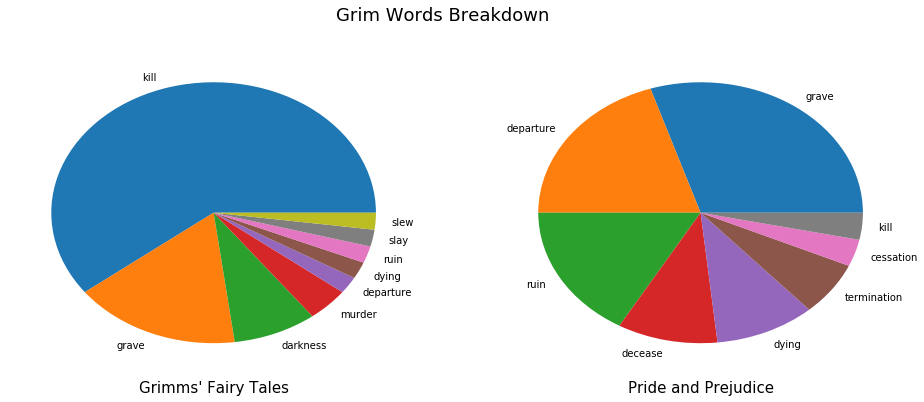

In [15]:
grimms_grim, grimms_cheery = word_df(grimms_df)
pride_grim, pride_cheery = word_df(pride_df)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle("Grim Words Breakdown", fontsize=18)

ax[0].set_xlabel("Grimms' Fairy Tales", fontsize=15)
ax[0].pie(grimms_grim['count'], labels=grimms_grim['word'])

ax[1].set_xlabel("Pride and Prejudice", fontsize=15)
ax[1].pie(pride_grim['count'], labels=pride_grim['word'])

plt.show()

While the analysis has been focused on 'How Many' so far, I would like to investigate its qualitative aspect. As seen on the pie charts, the word 'kill' is dominant in the grim words found in Grimms' Fairy Tales. On the other hand, it is the 'grave' for Pride and Prejudice. The word 'grave' could be neutral, but hardly is so the word 'kill'.

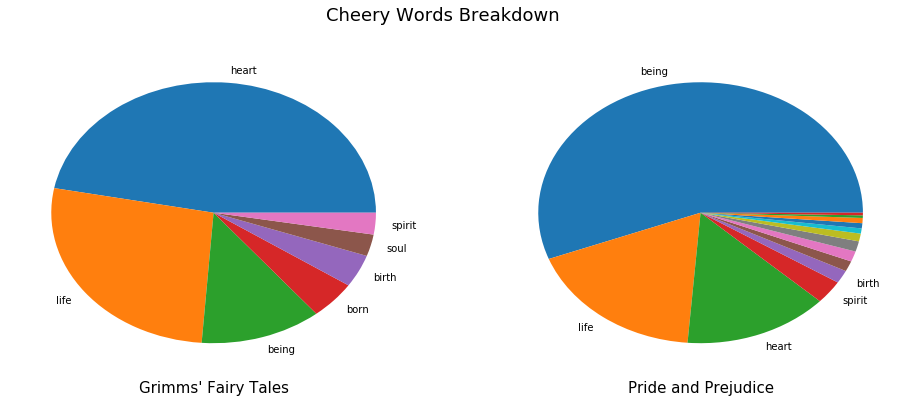

In [16]:
pride_cheery['word'] = pride_cheery.apply(lambda row : "" if row['count'] < 5 
                                          else row['word'], axis=1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle("Cheery Words Breakdown", fontsize=18)

ax[0].set_xlabel("Grimms' Fairy Tales", fontsize=15)
ax[0].pie(grimms_cheery['count'], labels=grimms_cheery['word'])

ax[1].set_xlabel("Pride and Prejudice", fontsize=15)
ax[1].pie(pride_cheery['count'], labels=pride_cheery['word'])

plt.show()

The same analysis for cheery word came as similar between two fictions in that the top 3 are the same in different order; 'being', 'heart', 'life'. However, Jane Austen's novel has more diverse cheery words, which is different from Grimms Brothers' Tales. In addition, the first ranked word 'heart' in Grimms' Fairy Tales could be used as negative. As part of qualitative investigation, I looked up the word in the novel and found they were used to describe a cruel scene such as "...her heart gave way and she died..." in the story <i>The Robber Brideroom</i>.

------
### 4. Conclusion

In [17]:
print("*** Grim Words in Grimms' Fairy Tales ***")
print("Overall:", sum(grimms_df['grim_total']))
print("Per Story:", round(sum(grimms_df['grim_total'])/len(grimms_df), 3))
print("Per Paragraph:", round(sum(grimms_df['grim_total'])/sum(grimms_df['paragraph']), 3))

*** Grim Words in Grimms' Fairy Tales ***
Overall: 48
Per Story: 0.774
Per Paragraph: 0.053


Through the investigation in both quantity and quality, it was found that 'Grimms' Fairy Tales' is quite scary. There are 53 grim words every 1,000 paragraph as opposed to 15 of 'Pride and Prejudice', which is more than triple times. It is more cruel too in terms of the words, considering their qualities. However, there are some points that would improve this project. One is enlarge the words sets so more specific words could be caught. The other is allow transformation of words. Especially, verbs can come in many other ways that will not violate the goal of the project. Nonetheless, it was enough to answer the question of the project; 'Grimms' Fairy Tales' is grim.